In [ ]:
import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
import PIL
from tensorflow.keras import layers
from keras.layers import Flatten
from tensorflow.keras import models
from keras.layers import Dense
from keras.layers import Dropout
from keras.models import Model

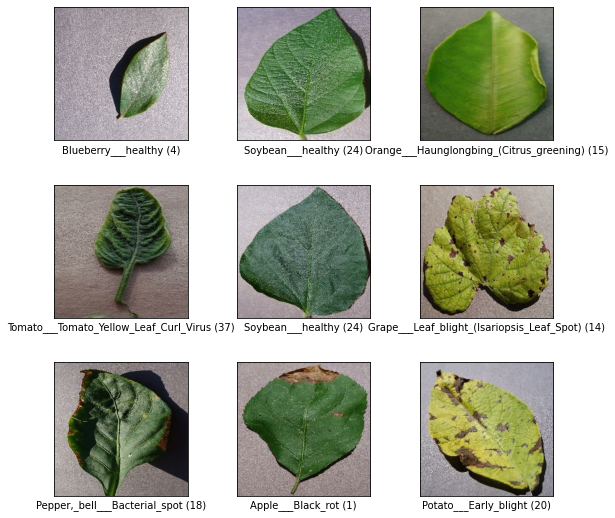

In [ ]:
plant_village, plant_village_info = tfds.load('plant_village', split='train', with_info=True,shuffle_files=True,as_supervised=True)
fig = tfds.show_examples(plant_village, plant_village_info)

In [ ]:
type(plant_village)

tensorflow.python.data.ops.dataset_ops._OptionsDataset

In [ ]:
ds_size= len(plant_village)

In [ ]:
train_size = int(0.7 * ds_size)
test_size1 = int(0.3 * ds_size)
train_dataset = plant_village.take(train_size)
test_dataset1 = plant_village.skip(train_size)
test_dataset1 = plant_village.take(test_size1)
test_size = int(0.5 * test_size1)
val_size = int(0.5 * test_size1)
test_dataset = test_dataset1.take(test_size)
test_dataset = test_dataset1.skip(test_size)
val_dataset = test_dataset1.take(val_size)

In [ ]:
num_classes = plant_village_info.features['label'].num_classes
print(num_classes)


38


Text(0.5, 1.0, 'Blueberry___healthy')

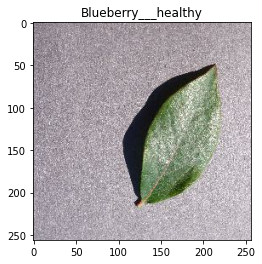

In [ ]:
get_label_name = plant_village_info.features['label'].int2str

image, label = next(iter(train_dataset))
plt.imshow(image)
plt.title(get_label_name(label))


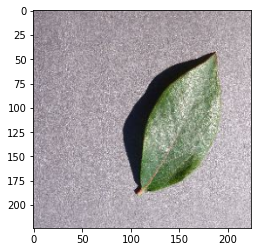

In [ ]:
IMG_SIZE = 224

resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMG_SIZE, IMG_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255)
])
result = resize_and_rescale(image)
plt.imshow(result)


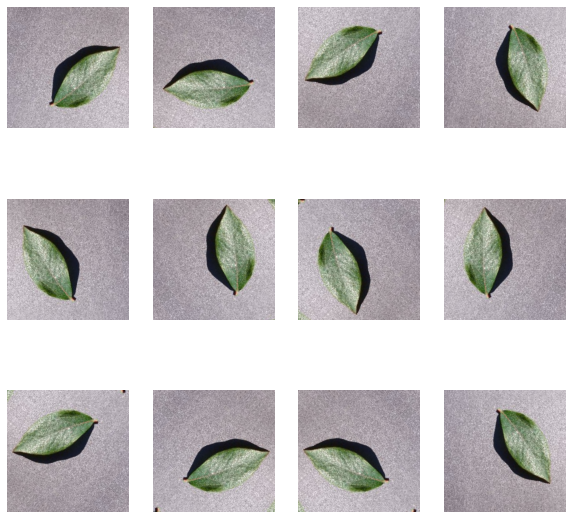

In [ ]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

# Add the image to a batch
image = tf.expand_dims(image, 0)


plt.figure(figsize=(10, 10))
for i in range(12):
  augmented_image = data_augmentation(image)
  ax = plt.subplot(3, 4, i + 1)
  plt.imshow(augmented_image[0])
  plt.axis("off")


In [ ]:
IMG_SIZE = 224
batch_size = 32
AUTOTUNE = tf.data.AUTOTUNE

def resize_and_rescale(image, label):
  image = tf.cast(image, tf.float32)
  image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
  image = (image / 255.0)
  return image, label


def augment(image_label, seed):
  image, label = image_label
  image, label = resize_and_rescale(image, label)
  image = tf.image.resize_with_crop_or_pad(image, IMG_SIZE + 6, IMG_SIZE + 6)
  # Make a new seed
  new_seed = tf.random.experimental.stateless_split(seed, num=1)[0, :]
  # Random crop back to the original size
  image = tf.image.stateless_random_crop(
      image, size=[IMG_SIZE, IMG_SIZE, 3], seed=seed)
  # Random brightness
  image = tf.image.stateless_random_brightness(
      image, max_delta=0.5, seed=new_seed)
  image = tf.clip_by_value(image, 0, 1)
  return image, label

In [ ]:
counter = tf.data.experimental.Counter()
train_ds = tf.data.Dataset.zip((train_dataset, (counter, counter)))

train_ds = (
    train_ds
    .shuffle(1000)
    .map(augment, num_parallel_calls=AUTOTUNE)
    .batch(batch_size)
    .prefetch(AUTOTUNE)
)

val_ds = (
    val_dataset
    .map(resize_and_rescale, num_parallel_calls=AUTOTUNE)
    .batch(batch_size)
    .prefetch(AUTOTUNE)
)

test_ds = (
    test_dataset
    .map(resize_and_rescale, num_parallel_calls=AUTOTUNE)
    .batch(batch_size)
    .prefetch(AUTOTUNE)
)

In [ ]:
# resnet = tf.keras.applications.ResNet152(
#     include_top=True, weights='imagenet', input_tensor=None,
#     input_shape=(224, 224, 3), pooling="max" ,classes=1000 )

# for layer in resnet.layers:
#   layer.trainable = False

vgg= tf.keras.applications.VGG16(
    include_top=True, weights='imagenet', input_tensor=None,
    input_shape=(224, 224, 3), pooling='max', classes=1000,
    classifier_activation='softmax'
)

# for layer in vgg.layers:
#   layer.trainable = False

In [ ]:
vgg.trainable = False

model_m = Model(vgg.input, vgg.layers[-2].output)
# model=tf.keras.Sequential()

model = models.Sequential()
model.add(model_m)
# model.add(Flatten())
model.add(Dense(units=256, activation='relu'))
# model.add(Dropout(0.5))
# model.add(Flatten())

model.add(Dense(units=512, activation='relu'))
# model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(units=38, activation='softmax'))

In [ ]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_1 (Functional)         (None, 4096)              134260544 
_________________________________________________________________
dense_3 (Dense)              (None, 256)               1048832   
_________________________________________________________________
dense_4 (Dense)              (None, 512)               131584    
_________________________________________________________________
flatten_1 (Flatten)          (None, 512)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 38)                19494     
Total params: 135,460,454
Trainable params: 1,199,910
Non-trainable params: 134,260,544
_________________________________________________________________


In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


In [ ]:
epochs=20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
1188/1188 [==============================] - 184s 154ms/step - loss: 2.0732 - accuracy: 0.4168 - val_loss: 0.7613 - val_accuracy: 0.7527
Epoch 2/20
1188/1188 [==============================] - 183s 154ms/step - loss: 0.9796 - accuracy: 0.6864 - val_loss: 0.8880 - val_accuracy: 0.7213
Epoch 3/20
1188/1188 [==============================] - 184s 154ms/step - loss: 0.8280 - accuracy: 0.7333 - val_loss: 0.5511 - val_accuracy: 0.8149
Epoch 4/20
1188/1188 [==============================] - 184s 154ms/step - loss: 0.7439 - accuracy: 0.7594 - val_loss: 0.4537 - val_accuracy: 0.8502
Epoch 5/20
1188/1188 [==============================] - 184s 154ms/step - loss: 0.6867 - accuracy: 0.7743 - val_loss: 0.4517 - val_accuracy: 0.8464
Epoch 6/20
1188/1188 [==============================] - 184s 154ms/step - loss: 0.6475 - accuracy: 0.7872 - val_loss: 0.4865 - val_accuracy: 0.8339
Epoch 7/20
1188/1188 [==============================] - 184s 155ms/step - loss: 0.6334 - accuracy: 0.7938 - val_

In [ ]:
loss, acc = model.evaluate(test_ds)
print("Accuracy", acc)

255/255 [==============================] - 35s 127ms/step - loss: 0.2984 - accuracy: 0.9006
Accuracy 0.90055251121521


In [ ]:
from sklearn import metrics
import numpy as np 
y_pred= np.around(model.predict(test_ds))

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
model.save('/content/drive/MyDrive/vgg16')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/vgg16/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/vgg16/assets
